<a href="https://colab.research.google.com/github/nadavo11/K_means_cluster/blob/master/EM_Clustering_with_K_means_3_gaussians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GMM implementation
### **with K-Means as an initial Model**

The Gaussian Mixture Model is discussed in previous paper, in this repository. there we talk about it's need of an initial "guess" model, for the algorithm to start, $K$ - Gaussians picked with thought or at random, defined by:
- $\mu_j$ - the mean of each gaussian
- ${\sigma_j}^2 $ - the covariance (matrix) of each gaussian
- $\phi_j$ - the "amplitude" of each gaussian
)

this time we will try a more interesting method - use the K means algorithm's output to initiate $µ_j$ . K- means is thorouly explained in another paper in this repository, and is "hard" algorithm, in contrast to EM, which is considerd "soft". in a few iterations,we get very close tothe conclution of the actual 
$\mu_j$


# GMM Algorithm Dealing With False K Parameter assignment


In this paper, we will also deliberatly provide our EM Clustering implementation with a false K value, inconsistant with how our data is formed.
think of it like looking ata dataset and thinking that it can be devided $k$ normaly distributed sub groups when in fact our dataset follows $k' \neq k$ bell curves (normaly distributed sub groups)


in this example, we are given two gaussians:

$µ_1 = \begin{bmatrix}
-1 \\
-1 
\end{bmatrix}$

$µ_2 = \begin{bmatrix}
1 \\
1 
\end{bmatrix}$

$\Sigma_1 = \begin{bmatrix}
0.8 & 0 \\
0 & 0.8
\end{bmatrix}$

$\Sigma_2 = \begin{bmatrix}
0.75 & -0.2 \\
-0.2 & 0.6
\end{bmatrix}$

we are given the probability for the first label:

$P_Z(1) = 0.7$

Let us define the datapiont generator:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 10000
k=2
d=2
# first Gussian
mean_1 = [-1, -1]
cov_1 = [[0.75, -0.2], [-0.2, 0.6]]

# second Gussian
mean_2 = [1, 1]
cov_2 = [[0.8, 0], [0, 0.8]]


def generate_normal_datapoint(guaussian_dist):
    mean = guaussian_dist[0]
    cov = guaussian_dist[1]
    dp = np.random.multivariate_normal(mean, cov,  check_valid='warn', tol=1e-8)
    dp = [dp[0],dp[1]]
    return dp

## Generating the dataset

In [ ]:
colors = []
data = []
for i in range(N):
    z = np.random.binomial(1, 0.7)
    d = {1: (mean_1, cov_1), 2: (mean_2, cov_2)}
    data.append(generate_normal_datapoint(d[z+1]))
    colors.append(np.random.uniform(0,1)/4+3*z/4)
    

now, lets plot the data (revealing the source of each data point) 

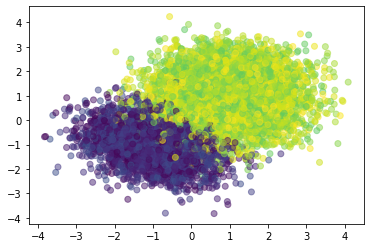

In [ ]:
data = np.array(data)

#colors = np.random.rand(N)
plt.scatter(data[:,0], data[:, 1], c=colors, alpha=0.5)
plt.show()

# EM Overview

we will use the EM algorithm to cluster the data.

pseudo code: The EM algorithm goes as follows

here is EM algorithm in pseudo code

1.until convergence, repeat:
    
####   -**E-step**:
   1. For each data point $x_i$:

        1. Compute the probability that $x_i$ belongs to each of the clusters, $p_{i,j}$

        2. Use these probabilities to compute the expected value of the cluster assignment, $w(i,j) = \frac{P(x_i \in Z_j)*\phi_j}{ \sum_{j = 0}^{k} P(x_i \in Z_j) \cdot \phi_j}$

####   -**M-step**:
   1. For each cluster $j$:

        1. compute the new mean, $\mu_j$

        2. compute the new variance, $\sigma^2_j$

        4. compute the new prior, $ \phi_j$
        
        
this is what the implementation looks like:

In [ ]:
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal as P


def E_step(data, phi, mu, sigma):
    """
       Perform E-step on GMM model
       Each datapoint will find its corresponding best cluster center
       ---
       Inputs:
            data: (n, d) array, where n is # of data points and d is # of dimensions
            phi: (k, d) array, where k is # of clusters
            mu: (k, d) array, where k is # of clusters and d is # of dimensions
            sigma: (k, d, d) array, where k is # of clusters and d is # of dimensions

       Returns:
            'w': (k,n) array indicating the cluster of each data point
                        where k is # of clusters and n is # of data points
       """
    n = len(data)
    k = len(phi)
    w = np.zeros((k, n))
    log_likelyhood = 0
    
    for i in range(n):
        norm_i = 0
        for j in range(k):
            w[j, i] = P(mu[j], sigma[j]).pdf(data[i]) * phi[j]
            norm_i += w[j, i]
        w[:, i] /= norm_i
        
        log_likelyhood -= np.log(norm_i)    # compute log-likelyhood
    return w, log_likelyhood


def M_step(data, w, phi, mu, sigma):
    """
    M-step: Update our estimate of μ, σ2 and using the new values of the latent variables z.
    Inputs:
        clusters: (n) array indicating the cluster of each data point
        data: (n, d) array, where n is # of data points and d is # of dimensions
        mu: (k, d) array, where k is # of clusters and d is # of dimensions
        sigma: (k, d, d) array, where k is # of clusters and d is # of dimensions

    Returns:
        mu: (k, d) array, where k is # of clusters and d is # of dimensions
        sigma: (k, d, d) array, where k is # of clusters and d is # of dimensions
    """
    sum_of_all_w = np.sum(w)
    # iterate over each gaussian, calculate μ, σ2:

    for j in range(len(mu)):
        sum_over_wj = np.sum(w[j])
        # μ <- (1/sum over wj) * weighted sum over all the data points
        mu[j] = np.sum(np.array([xi*w[j,i] for i, xi in enumerate(data)]), axis=0) / sum_over_wj
        # σ2 <- wheighted sum over all the data points in cluster((datapoint value - μ_new)**2)
        sigma[j] = np.sum(np.array([np.outer((xi - mu[j]).T, xi - mu[j]) * w[j, i] for i, xi in enumerate(data)]), axis=0)/sum_over_wj

        phi[j] = sum_over_wj/sum_of_all_w

    return phi, mu, sigma

# Input: data, model

def EM(data, initial_model):
    # 1. Initialize model parameters
    phi = initial_model[0]
    mu = initial_model[1]
    sigma = initial_model[2]

    # 2. while not converged:
    converged = False
    i = 0
    iteration_log_likelihood = [0.0]
    while not converged and i<150:

        # 2.1     E-step: compute expected value of latent variable given current parameters
        w,lol = E_step(data , phi, mu, sigma)
        iteration_log_likelihood.append(lol)
        # 4.     M-step: update parameters to maximize expected likelihood
        phi, mu, sigma = M_step(data, w, phi, mu, sigma)
        
        # Plot:
        if i%20 == 0 or i < 5:
            plt.scatter(data[:,0], data[:, 1], c='red', alpha=0.1)
            for t in range(k):
                draw_contour(phi[t],mu[t],k*sigma[t])
            plt.title("iteration #" + str(i))
            plt.show()
            print("φ: ",phi,"\n\nμ: ", mu,"\n\nσ2: ", sigma,"\n\nlog likelyhood: ", lol)
        i += 1
        converged = (abs(iteration_log_likelihood[i]-iteration_log_likelihood[i-1]) < 0.0001)
    # 5. return model
    return phi, mu, sigma,  iteration_log_likelihood

def draw_contour(phi,mu,sigma):
    N    = 200
    X    = np.linspace(-4, 4, N)
    Y    = np.linspace(-4, 4, N)
    X, Y = np.meshgrid(X, Y)
    pos  = np.dstack((X, Y))
    rv   = P(mu, sigma*phi)
    Z    = rv.pdf(pos)
    plt.contour(X, Y, Z)


# Initial Model:

first, we will need an initial model to start with. EM algorithm demands initial value  $\theta_0$ ie. initial values 
for:  $\mu_j , \sigma^2_j , \phi_j$

this time we will try to use K - means algorithm to help us generate the initial guess.
k-means outputs, as its name indicates, k - vctors, representing the means, $\mu_j$ of the predicted gaussians.  
this is an asset for us, as $\mu_j$ is an important part of the model.

but we need not stop there, as K-means inner operation deals with anuther vital piece of information: the size of each predicted cluster.
we can leverage this information to estimate $\phi_j$ for our initial guess: 

$\phi_j = P(Z = j) $ 

so K-means predicts:

$\phi_j = \frac{|cluster_j| }{|X|}$ 

where $|X|$ is the number of datapoints

furthermore, after estimating $mu$, and fetching the clusters predicted by k-means nothing stops us from getting a pretty good initial guess of $\sigma_j^2$:

$\sigma_j^{2 ,(0)} = \frac{1}{n} $  $\sum_{x \in cluster_j} (x -\mu_j^{(0)})^2 $
as this is a fair assumption for the value of $\sigma^2$ given the cluster.

so, we get valuable information at a low computational price.


In [ ]:
def K_means_cluster(k, data):
    # 1. randomly select k data points as
    #    centroids
    centroids = []
    for i in range(k):
        mean = np.random.uniform(-3,3,size=2)
        centroids.append(mean)
    i=0
    dif = 1
    tol= 0.001
    # 3. repeat until the centroids converge:
    while (i <= 25) and dif > tol: #TODO: add condition
        previous_centroids = np.array(centroids)

        # 2. calculate the distance between
        #    each data point and each centroid
        d = []
        for dp in data:
            distance = [np.linalg.norm(dp - ci) for ci in centroids]
            d.append(distance)
        d = np.array(d)


        # 4. assign each data point to the cluster with the nearest centroid
        clusters = [[] for t in range(k)]
        for j, dp in enumerate(d):
            closest_centroid = np.argmin(dp)
            clusters[closest_centroid].append(list(data[j]))

        fig = plt.figure()
        ax1 = fig.add_subplot()
        colors = ['r','b','g','y']
        for n in range(k):
            x = [row[0] for row in clusters[n]]
            y = [row[1] for row in clusters[n]]
            ax1.scatter( x, y , c=colors[n%4],alpha=0.03, label='cluster'+str(n))

        ax1.scatter([row[0] for row in np.array(centroids)], [row[1] for row in np.array(centroids)], c='m',marker="x",label='centroids')


        plt.legend(loc='upper left');
        plt.title("K-means iteration #" + str(i))
        plt.show()

        # 5. recalculate the centroid of each cluster
        for j, c in enumerate(clusters):
            centroids[j] = np.mean(c,axis=0)
        
        #calculate the convergence condition
        dif = 0
        for j, c in enumerate(centroids):
            dif += abs(np.linalg.norm(c-np.array(previous_centroids[j])))
        print("dif", dif)
        
        i +=1
    # phi is the probability of each cluster in the data
    phi =np.array([len(clusters[t])/len(data) for t in range(k)])
    
    sigma = np.zeros((k,2,2))
    for j, c in enumerate(clusters):
        sigma[j] = np.mean([np.outer((d - centroids[j]).T, d - centroids[j]) for d in c],axis = 0)
        
    return phi, np.array(centroids), sigma



In [ ]:
def initial_model(k,d,data):
    """

    :param k: # of Gaussians in model
    :param d: # of dimentions of datapoints
    :return: an arbitrary initial condition  model for EM. containing:
             phi: amplitude of Gaussians, np array (k)
             mu: np array(k,d)
             sigma: covariance matrix of gausians, np aray (k,d,d)


    """

    phi, mu, sigmas = K_means_cluster(k, data)
    print("phi: ",phi,"\n\nmu: ", mu,"\n\nsigma: ", sigmas)
    return phi, mu, sigmas

## convergence conditon:

we will also like to decide when to stop the algorithm. for one thing, we will limit the maximal # of iterations to a fixed number. for another, the algorithm increases the log likelihood, i.e., $ log P(x^n |/theta^t$
so we will calculate the log likelihood at each step, as follows:

Log Likelihood:

$ log P(x^n |\theta ^t )= log(\sum_j P(x^n , z^n ;\theta ^t))$


$= log( \prod_i\sum_j  N(x_i, \mu_j , \sigma^2_j ; \theta ^t)* \phi_j)$


$= \sum_i log( \sum_j  w(j,i))$

and compare to previous value, to check for convergence.

## False K Clustering:

Now, let us check how te algorithm behaves when provided with a false K value, 3 when in fact the data fits a 2 gaussians model: 

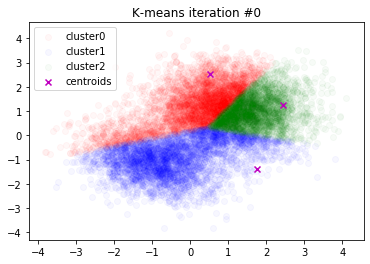

dif 4.197010374399511


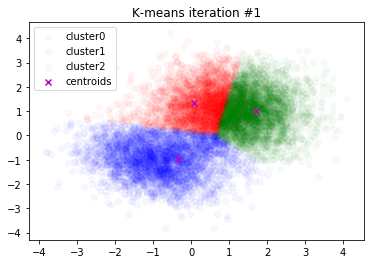

dif 0.6139867990592079


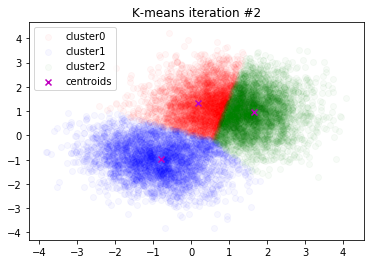

dif 0.20763092820787918


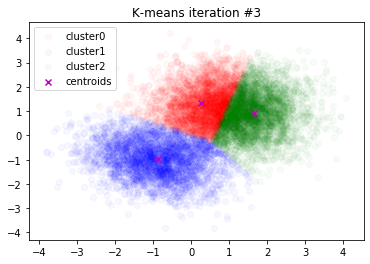

dif 0.10934128857355667


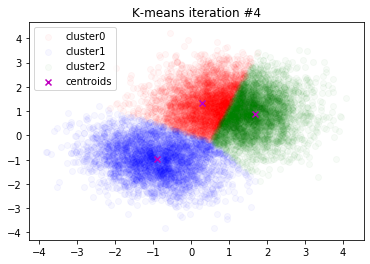

dif 0.07027594604021253


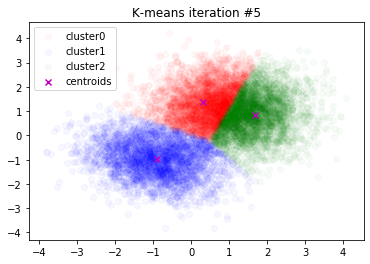

dif 0.06913858063770112


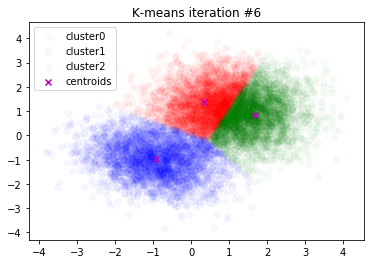

dif 0.0716212893829308


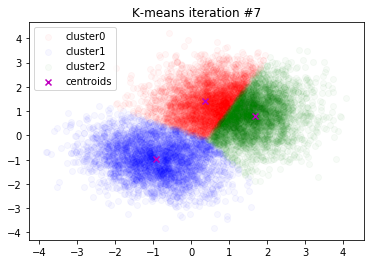

dif 0.05868238308011722


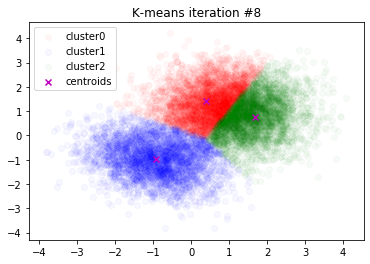

dif 0.05598550687269904


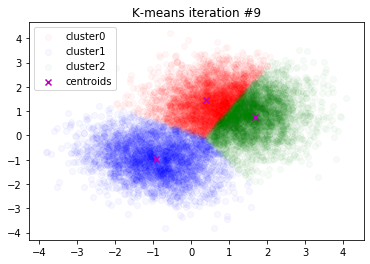

dif 0.04502183056037687


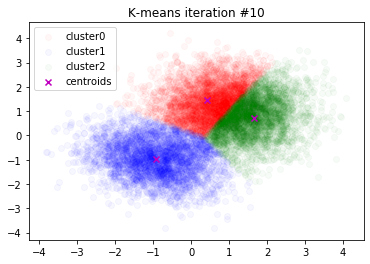

dif 0.04043441536300772


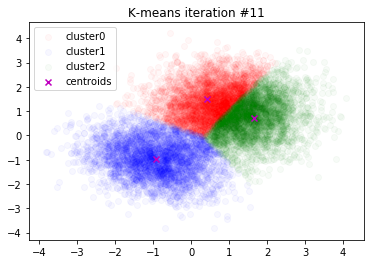

dif 0.03551838321341236


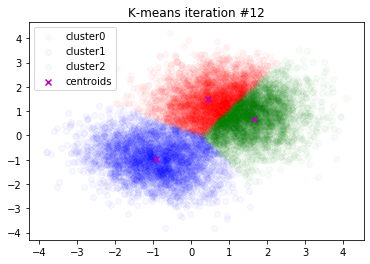

dif 0.030016769316635848


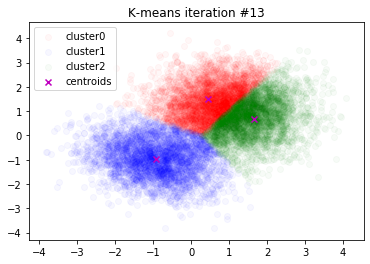

dif 0.032065929280628236


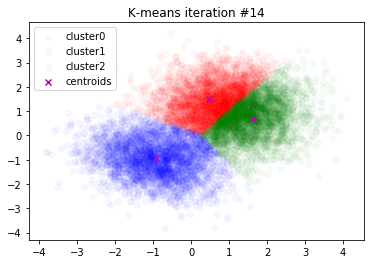

dif 0.026959629585424055


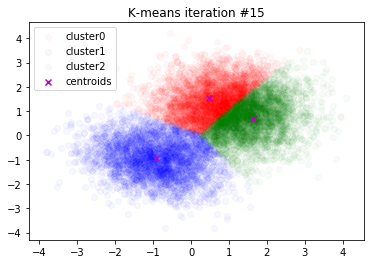

dif 0.019601605791480174


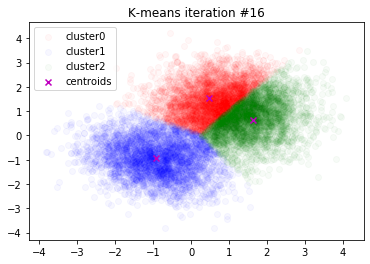

dif 0.014031159978752537


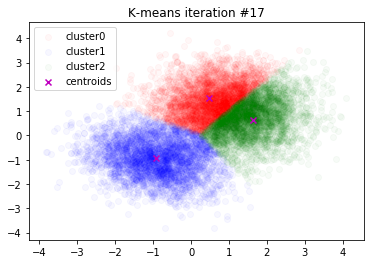

dif 0.012464703863267463


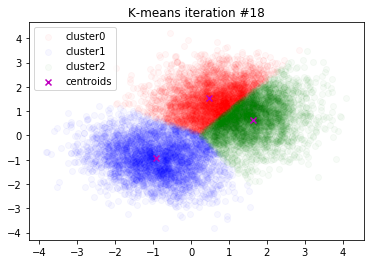

dif 0.007382214896611785


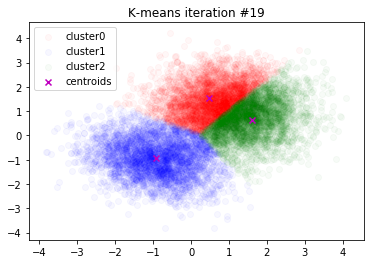

dif 0.005854036442624798


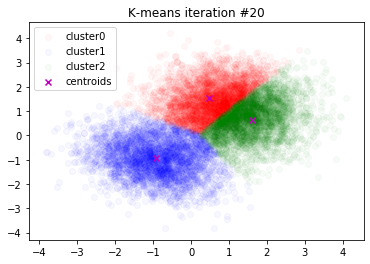

dif 0.004728452091701986


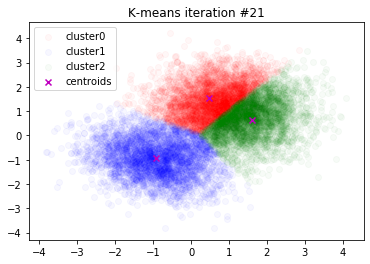

dif 0.0065378494760482825


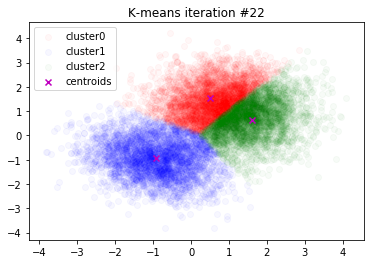

dif 0.005058992979159892


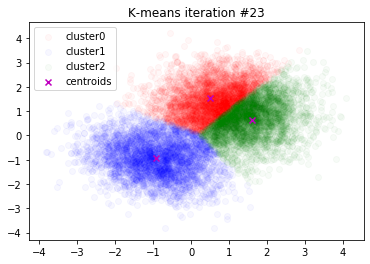

dif 0.005515896173137736


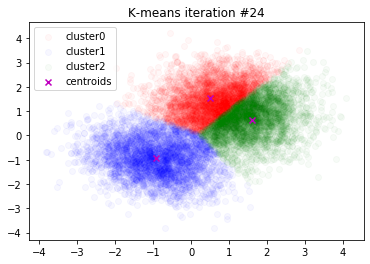

dif 0.004450088977700839


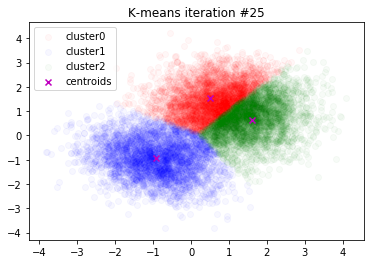

dif 0.004388692710809496
phi:  [0.3177 0.3451 0.3372] 

mu:  [[ 0.49384316  1.56372042]
 [-0.92805617 -0.94167697]
 [ 1.6117344   0.6309596 ]] 

sigma:  [[[ 0.45659902  0.16945881]
  [ 0.16945881  0.47273563]]

 [[ 0.71504986 -0.13672678]
  [-0.13672678  0.58513144]]

 [[ 0.43563854  0.16696038]
  [ 0.16696038  0.5423321 ]]]


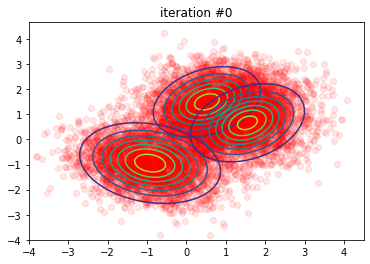

φ:  [0.3200364  0.33883855 0.34112505] 

μ:  [[ 0.51715191  1.49717561]
 [-0.92425612 -0.94422572]
 [ 1.54712998  0.66066745]] 

σ2:  [[[ 0.51052674  0.16245569]
  [ 0.16245569  0.54103765]]

 [[ 0.76801268 -0.13946314]
  [-0.13946314  0.62019181]]

 [[ 0.51063136  0.16381481]
  [ 0.16381481  0.58758656]]] 

log likelyhood:  31081.142024392037


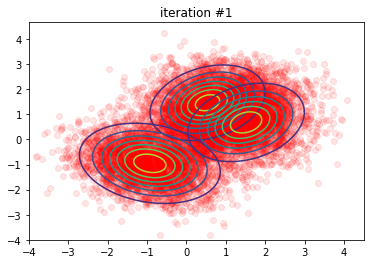

φ:  [0.32160542 0.3346779  0.34371667] 

μ:  [[ 0.53283952  1.46227326]
 [-0.92995135 -0.95246036]
 [ 1.51278294  0.67809704]] 

σ2:  [[[ 0.54165604  0.1512646 ]
  [ 0.1512646   0.57636723]]

 [[ 0.77412207 -0.143382  ]
  [-0.143382    0.61925558]]

 [[ 0.54914817  0.1528165 ]
  [ 0.1528165   0.61142242]]] 

log likelyhood:  30867.551738347745


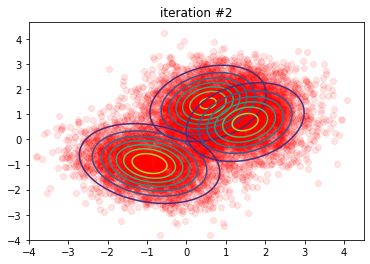

φ:  [0.32295929 0.33125227 0.34578844] 

μ:  [[ 0.54476716  1.43716911]
 [-0.9377076  -0.96130856]
 [ 1.48871023  0.69079625]] 

σ2:  [[[ 0.56422713  0.14185573]
  [ 0.14185573  0.59897608]]

 [[ 0.77059373 -0.14893533]
  [-0.14893533  0.61295722]]

 [[ 0.57382198  0.14244991]
  [ 0.14244991  0.62879214]]] 

log likelyhood:  30806.295103087516


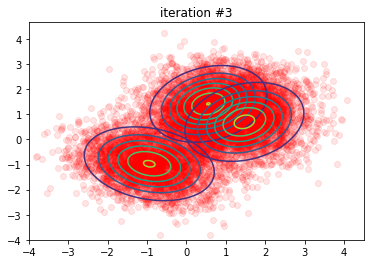

φ:  [0.32416925 0.32828535 0.34754539] 

μ:  [[ 0.55424463  1.41685334]
 [-0.9454373  -0.96941003]
 [ 1.46974406  0.70069597]] 

σ2:  [[[ 0.5819834   0.13459458]
  [ 0.13459458  0.61570899]]

 [[ 0.76530258 -0.15467469]
  [-0.15467469  0.60662618]]

 [[ 0.59188616  0.13402509]
  [ 0.13402509  0.64295082]]] 

log likelyhood:  30776.807872881283


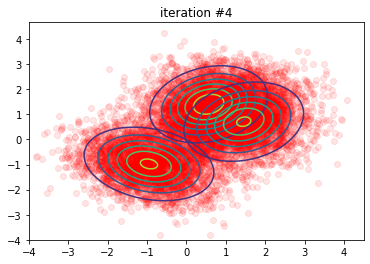

φ:  [0.32525047 0.32569658 0.34905295] 

μ:  [[ 0.56200581  1.39960622]
 [-0.95249126 -0.97647891]
 [ 1.45401757  0.70875807]] 

σ2:  [[[ 0.59655678  0.12899468]
  [ 0.12899468  0.62917745]]

 [[ 0.76015699 -0.15991054]
  [-0.15991054  0.60117284]]

 [[ 0.60618854  0.12732209]
  [ 0.12732209  0.65500052]]] 

log likelyhood:  30759.474257791007


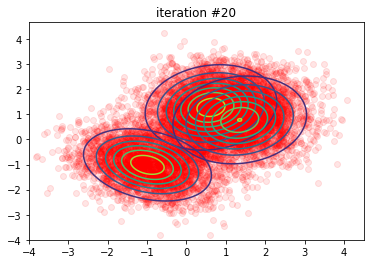

φ:  [0.33166587 0.31146345 0.35687068] 

μ:  [[ 0.62221165  1.27556139]
 [-0.99094149 -1.01353529]
 [ 1.35167819  0.77675152]] 

σ2:  [[[ 0.68833059  0.09483773]
  [ 0.09483773  0.71346922]]

 [[ 0.73351431 -0.1869528 ]
  [-0.1869528   0.57542732]]

 [[ 0.69030935  0.0807907 ]
  [ 0.0807907   0.73229793]]] 

log likelyhood:  30715.728564376284


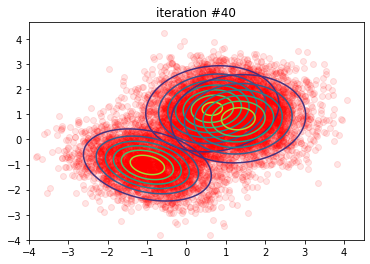

φ:  [0.33261281 0.31028761 0.35709959] 

μ:  [[ 0.65646761  1.22079095]
 [-0.99331    -1.01690088]
 [ 1.3160499   0.82347301]] 

σ2:  [[[ 0.71856069  0.07682726]
  [ 0.07682726  0.73989125]]

 [[ 0.73263285 -0.18896265]
  [-0.18896265  0.57313666]]

 [[ 0.71426531  0.05290917]
  [ 0.05290917  0.75454084]]] 

log likelyhood:  30712.28657200349


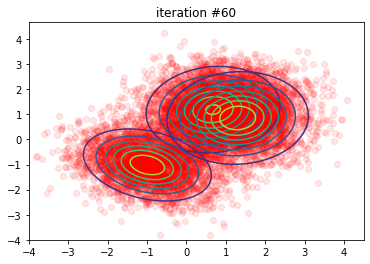

φ:  [0.33325541 0.31006444 0.35668015] 

μ:  [[ 0.67468155  1.18689876]
 [-0.99339591 -1.0177062 ]
 [ 1.29885026  0.85397213]] 

σ2:  [[[ 0.73310032  0.06757796]
  [ 0.06757796  0.75291822]]

 [[ 0.73304076 -0.1893046 ]
  [-0.1893046   0.57255168]]

 [[ 0.72438119  0.03648428]
  [ 0.03648428  0.76520799]]] 

log likelyhood:  30711.32208393226


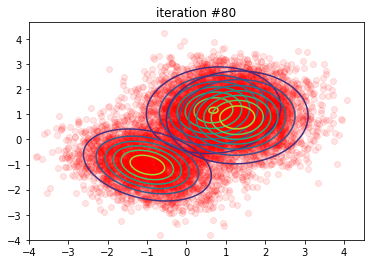

φ:  [0.33392889 0.30986094 0.35621018] 

μ:  [[ 0.68568529  1.16120928]
 [-0.99349628 -1.01838439]
 [ 1.28849265  0.8769459 ]] 

σ2:  [[[ 0.7424895   0.06234124]
  [ 0.06234124  0.76165232]]

 [[ 0.73338072 -0.1895906 ]
  [-0.1895906   0.57208259]]

 [[ 0.72979342  0.02481971]
  [ 0.02481971  0.77181349]]] 

log likelyhood:  30710.87048270066


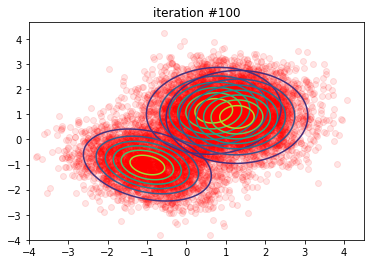

φ:  [0.33461165 0.30963803 0.35575032] 

μ:  [[ 0.69283981  1.1400016 ]
 [-0.99367148 -1.01906564]
 [ 1.2816428   0.89575321]] 

σ2:  [[[ 0.74940061  0.05919355]
  [ 0.05919355  0.76824678]]

 [[ 0.73365145 -0.18989109]
  [-0.18989109  0.57163362]]

 [[ 0.73292275  0.01556639]
  [ 0.01556639  0.77630767]]] 

log likelyhood:  30710.601726990015


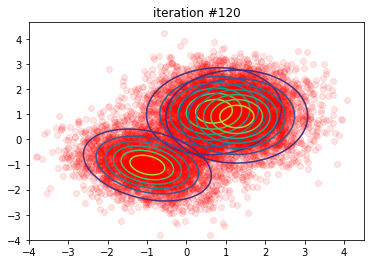

φ:  [0.33528751 0.30939404 0.35531845] 

μ:  [[ 0.69772421  1.12160262]
 [-0.9939153  -1.0197647 ]
 [ 1.27680363  0.91194422]] 

σ2:  [[[ 0.75492242  0.05726622]
  [ 0.05726622  0.77354236]]

 [[ 0.73386709 -0.19021191]
  [-0.19021191  0.57119142]]

 [[ 0.73480466  0.00772869]
  [ 0.00772869  0.77954272]]] 

log likelyhood:  30710.416861853446


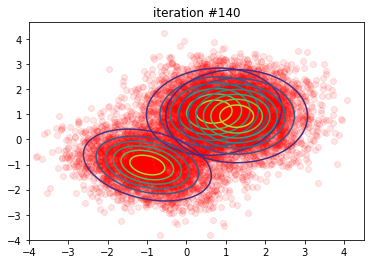

φ:  [0.33594707 0.30913049 0.35492243] 

μ:  [[ 0.70122684  1.10512374]
 [-0.99421928 -1.02048369]
 [ 1.27314303  0.92634431]] 

σ2:  [[[ 0.7596281   0.05612198]
  [ 0.05612198  0.77794477]]

 [[ 0.73403677 -0.19055227]
  [-0.19055227  0.570752  ]]

 [[ 0.73598246  0.0007981 ]
  [ 0.0007981   0.78196017]]] 

log likelyhood:  30710.276944081605


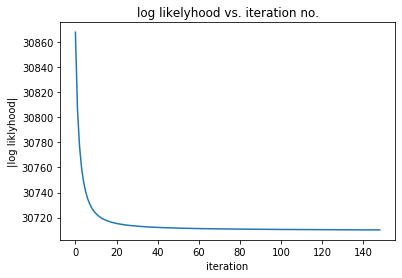

In [ ]:
k=3
d=2

phi, mu, sigma, lol = EM(data,initial_model(k,d,data))

plt.plot(range(len(lol[2:])),lol[2:])
plt.title("log likelyhood vs. iteration no.")
plt.xlabel("iteration")
plt.ylabel("|log liklyhood|")
plt.show()

# Conclusion
so, once more, the algorithm did not converge at under 150 iterations.
The K-means algorithm provide us with a good initial model, right on the start one gaussian has relatively accurate parameters, the other is "cut in half". From there, EM "piles up" the oter two on each other, making them two copies of the same gaussian, with roughly the same parameters $\mu , \sigma^2$ as the corresponding original gaussian, and half the amplitude $\phi$. the two sum up to the original distribution.
As surprising as it is, enven though we provided an unmaching parameter to the model, the algorithm performed well nonetheless